In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
import cmath
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
def nc(x):
    x = x.astype(float)
    return (x-np.mean(x))/np.std(x)

In [14]:
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
# OU ; input
tau= 1
D = 27*10**5
OU=np.zeros(len(T))
mu, sigma = 0, 1
for i in range(len(T)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
cutoffFreq = 0.5
b, a = signal.butter(2, 2*cutoffFreq*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)

(-10, 1)

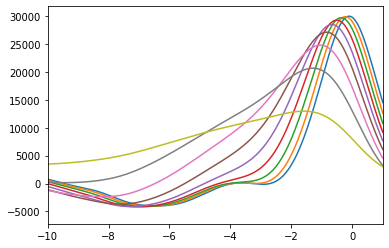

In [15]:
lambdas = np.arange(0.1,1,0.1)
betas = (1-lambdas)/lambdas
time_dis3 = []
for beta in betas:
    g = 1
    zs = []
    z = 0
    xs = LPOU-min(LPOU)
    for x in xs:
        dz = (-beta*z+g*x)*dt
        z = z+dz
        zs.append(z)
    zs = np.array(zs)
    xzCor = np.correlate(nc(xs),nc(zs), 'same')
    plt.plot(T-np.mean(T), xzCor)
    time_dis3.append((T-np.mean(T))[np.argmax(xzCor)])
plt.xlim([-10, 1])

(-10, 1)

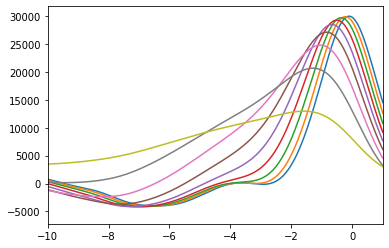

In [45]:
lambdas = np.arange(0.1,1,0.1)
betas = (1-lambdas)/lambdas
time_dis4 = []
for beta in betas:
    g = beta
    zs = []
    z = 0
    xs = LPOU-min(LPOU)
    for x in xs:
        dz = (-beta*z+g*x)*dt
        z = z+dz
        zs.append(z)
    zs = np.array(zs)
    xzCor = np.correlate(nc(xs),nc(zs), 'same')
    plt.plot(T-np.mean(T), xzCor)
    time_dis4.append((T-np.mean(T))[np.argmax(xzCor)])
plt.xlim([-10, 1])

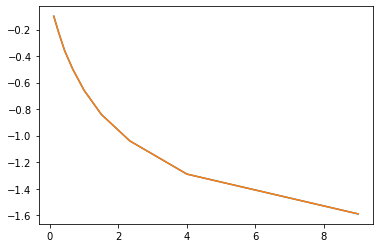

In [17]:
plt.plot(1./betas,time_dis3)
plt.plot(1./betas,time_dis4)

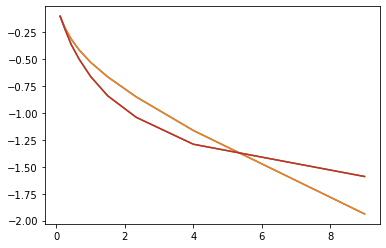

In [18]:
plt.plot(1./betas,time_dis1)
plt.plot(1./betas,time_dis2)
plt.plot(1./betas,time_dis3)
plt.plot(1./betas,time_dis4)

In [ ]:
import cmath

In [ ]:
lambdas = np.arange(0.1,1,0.1)
betas = (1-lambdas)/lambdas
time_dis4 = []
for Lambda in lambdas:
    xzCor = np.correlate(nc(xs),nc(zs), 'same')
    plt.plot(T-np.mean(T), xzCor)
    time_dis4.append((T-np.mean(T))[np.argmax(xzCor)])
plt.xlim([-10, 1])

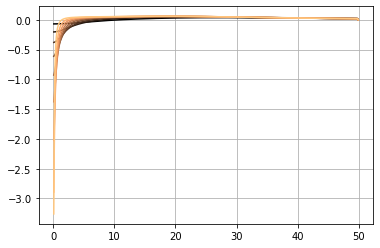

In [149]:
dOmega = 0.1
k = 40.
alpha = 40.
g = 20.
phi = 1.
beta = 10.
fig, ax = plt.subplots()
ax.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, len(betas)))))
for beta in betas:
    omega = np.arange(dOmega,50,dOmega)
    H = k/(omega*1j+alpha+(k*phi*g/(omega*1j+beta)))#/(omega*1j)
    G = np.abs(H)
    Phi = np.angle(H)
    delta = -np.append(np.diff(Phi),0)/dOmega
#     plt.plot(omega,G)
#     plt.plot(Phi)
    plt.plot(omega, delta)
plt.grid()

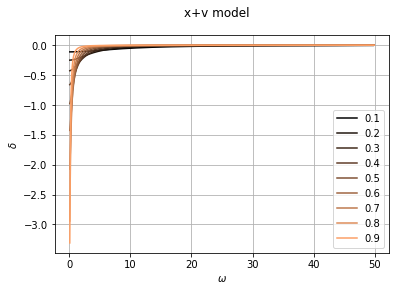

In [148]:
fig, ax = plt.subplots()
ax.set_prop_cycle(plt.cycler('color', plt.cm.copper(np.linspace(0, 1, 11))))
fig.suptitle('x+v model')
for Lambda in lambdas:
    omega = np.arange(dOmega,50,dOmega)
    H = (1-Lambda+Lambda*1j*omega)#/(omega*1j)
    G = np.abs(H)
    Phi = np.angle(H)
    delta = -np.append(np.diff(Phi),0)/dOmega
    ax.plot(omega, delta)
#     plt.plot(omega/2/np.pi,G)
#     plt.plot(omega/2/np.pi,Phi)
ax.legend( [str(round(Lambda,2)) for Lambda in lambdas], loc='best')
ax.set_ylabel(r'$\delta$')
ax.set_xlabel(r'$\omega$')
ax.grid()

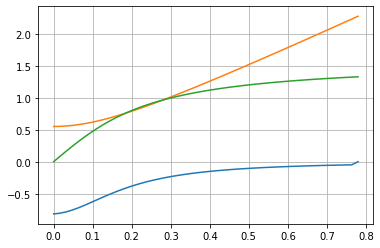

In [73]:
Lambda = 0.45
omega = np.arange(0,5,dOmega)
H = (1-Lambda+Lambda*1j*omega)
G = np.abs(H)
Phi = np.angle(H)
delta = -np.append(np.diff(Phi),0)/dOmega
plt.plot(omega/2/np.pi, delta)
plt.plot(omega/2/np.pi,G)
plt.plot(omega/2/np.pi,Phi)
plt.grid()

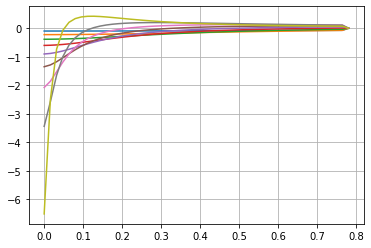

In [67]:
for beta in betas:
    g = beta
    omega = np.arange(0,5,dOmega)
    H = k/(omega*1j+alpha+(k*phi*g/(omega*1j+beta)))
    G = np.abs(H)
    Phi = np.angle(H)
    delta = -np.append(np.diff(Phi),0)/dOmega
    plt.plot(omega/2/np.pi, delta)
plt.grid()

In [83]:
omega

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])

In [ ]:
RL = (-k*g+omega)

In [82]:
betas

array([9.        , 4.        , 2.33333333, 1.5       , 1.        ,
       0.66666667, 0.42857143, 0.25      , 0.11111111])

In [116]:
lambdas

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])